In [52]:
import math
import os
import time
import glob
from contextlib import nullcontext
from datetime import datetime
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from PIL import Image

import torch
import torch.nn.functional as F
from model import Transformer, ModelArgs, apply_rotary_emb, repeat_kv
from torch.distributed import destroy_process_group, init_process_group
from torch.nn.parallel import DistributedDataParallel as DDP

from enwiki import Task
from tokenizer import Tokenizer

In [53]:
checkpoint = 'mo_attn/ckpt.pt'
checkpoint_baseline = 'vanilla/ckpt.pt'
data_cache_dir = "data"
batch_size = 1  # if gradient_accumulation_steps > 1, this is the micro-batch size
max_seq_len = 512
vocab_source = "enwik8" # llama2|custom; use Lllama 2 vocab from Meta, or custom trained
vocab_size = 244 # the Llama 2 tokenizer has 32K tokens
seed = 1337
device = 'cuda' if torch.cuda.is_available() else 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
dtype = "float32"
compile = False # use PyTorch 2.0 to compile the model to be faster

In [54]:
attn_maps = []
def attn_hook(module, args, output):
    x, freqs_cos, freqs_sin = args[0], args[1], args[2]
    bsz, seqlen, _ = x.shape
    if not module.share_qk:
        xq, xk = module.wq(x), module.wk(x)
    else:
        xk = module.wk(x)
        xq = torch.cat([w(x) for w in module.wq], dim=-1)
    xq = xq.view(bsz, seqlen, module.n_local_heads, module.head_dim)
    xk = xk.view(bsz, seqlen, module.n_local_kv_heads, module.head_dim)
    # RoPE relative positional embeddings
    xq, xk = apply_rotary_emb(xq, xk, freqs_cos, freqs_sin)

    # grouped multiquery attention: expand out keys and values
    xk = repeat_kv(xk, module.n_rep)  # (bs, seqlen, n_local_heads, head_dim)

    # make heads into a batch dimension
    xq = xq.transpose(1, 2)  # (bs, n_local_heads, seqlen, head_dim)
    xk = xk.transpose(1, 2)
    scores = torch.matmul(xq, xk.transpose(2, 3)) / math.sqrt(module.head_dim)
    if hasattr(module, 'mask'):
        mask = module.mask
    else:
        mask = torch.full((1, 1, seqlen, seqlen), float("-inf"))
        mask = torch.triu(mask, diagonal=1).to(x.device)
    scores = scores + mask[:, :, :seqlen, :seqlen]   # (bs, n_local_heads, seqlen, cache_len + seqlen)
    scores = F.softmax(scores.float(), dim=-1).type_as(xq)
    attn_maps.append(scores.detach().cpu())

In [55]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# init from a model saved in a specific directory
checkpoint_dict = torch.load(checkpoint, map_location=device)
gptconf = ModelArgs(**checkpoint_dict['model_args'])
model = Transformer(gptconf)

num_layers = len(model.layers)
hook_handles = []
for i in range(num_layers):
    hook_handles.append(model.layers[i].attention.register_forward_hook(attn_hook))

state_dict = checkpoint_dict['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)

model.eval()
model.to(device)

Transformer(
  (tok_embeddings): Embedding(244, 288)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): Attention(
        (wk): Linear(in_features=288, out_features=288, bias=False)
        (wq): ModuleList(
          (0): Linear(in_features=288, out_features=288, bias=False)
        )
        (wv): Linear(in_features=288, out_features=288, bias=False)
        (wo): Linear(in_features=288, out_features=288, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=288, out_features=768, bias=False)
        (w2): Linear(in_features=768, out_features=288, bias=False)
        (w3): Linear(in_features=288, out_features=768, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
 

In [56]:
iter_batches = partial(
    Task.iter_batches,
    batch_size=batch_size,
    max_seq_len=max_seq_len,
    vocab_size=vocab_size,
    vocab_source=vocab_source,
    device=device,
    num_workers=0,
)

In [57]:
batch_iter = iter_batches(split="test")
X, Y = next(batch_iter)
with ctx:
    logits = model(X, Y)
    bpc = model.last_bpc.item()
print(bpc)
attn_maps_1 = attn_maps.copy()
attn_maps.clear()
del model
torch.cuda.empty_cache()

Created a PretokDataset with rng seed 42
0.03852469474077225


In [58]:
checkpoint_dict = torch.load(checkpoint_baseline, map_location=device)
gptconf = ModelArgs(**checkpoint_dict['model_args'])
model = Transformer(gptconf)

num_layers = len(model.layers)
hook_handles = []
for i in range(num_layers):
    hook_handles.append(model.layers[i].attention.register_forward_hook(attn_hook))

state_dict = checkpoint_dict['model']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict, strict=False)

model.eval()
model.to(device)

Transformer(
  (tok_embeddings): Embedding(244, 288)
  (dropout): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attention): Attention(
        (wk): Linear(in_features=288, out_features=288, bias=False)
        (wq): Linear(in_features=288, out_features=288, bias=False)
        (wv): Linear(in_features=288, out_features=288, bias=False)
        (wo): Linear(in_features=288, out_features=288, bias=False)
        (attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (w1): Linear(in_features=288, out_features=768, bias=False)
        (w2): Linear(in_features=768, out_features=288, bias=False)
        (w3): Linear(in_features=288, out_features=768, bias=False)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=288, ou

In [59]:
with ctx:
    logits = model(X, Y)
    bpc = model.last_bpc.item()
print(bpc)
attn_maps_2 = attn_maps.copy()
attn_maps.clear()
del model
torch.cuda.empty_cache()

0.027980217710137367


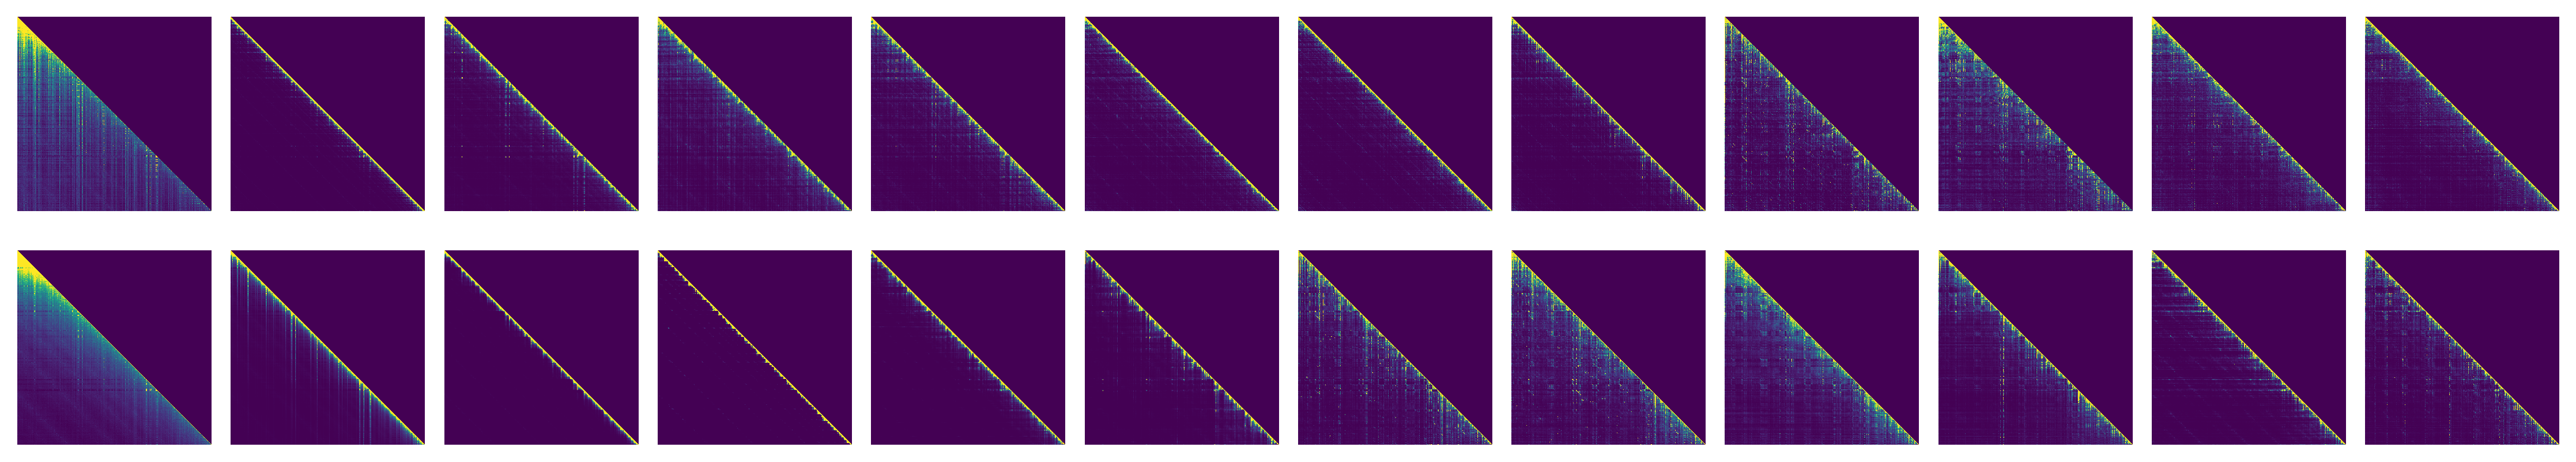

In [60]:
fig, axs = plt.subplots(2, len(attn_maps_1), figsize=(15, 3), dpi=300)
for i, attn_map in enumerate(attn_maps_2):
    attn_mat = attn_map[0].sum(0).numpy()
    vmin, vmax = np.percentile(attn_mat, [50, 99])
    axs[0,i].matshow(attn_mat, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    axs[0,i].axis('off')
for i, attn_map in enumerate(attn_maps_1):
    attn_mat = attn_map[0].sum(0).numpy()
    vmin, vmax = np.percentile(attn_mat, [50, 99])
    axs[1,i].matshow(attn_mat, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
    axs[1,i].axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.1)
plt.show()

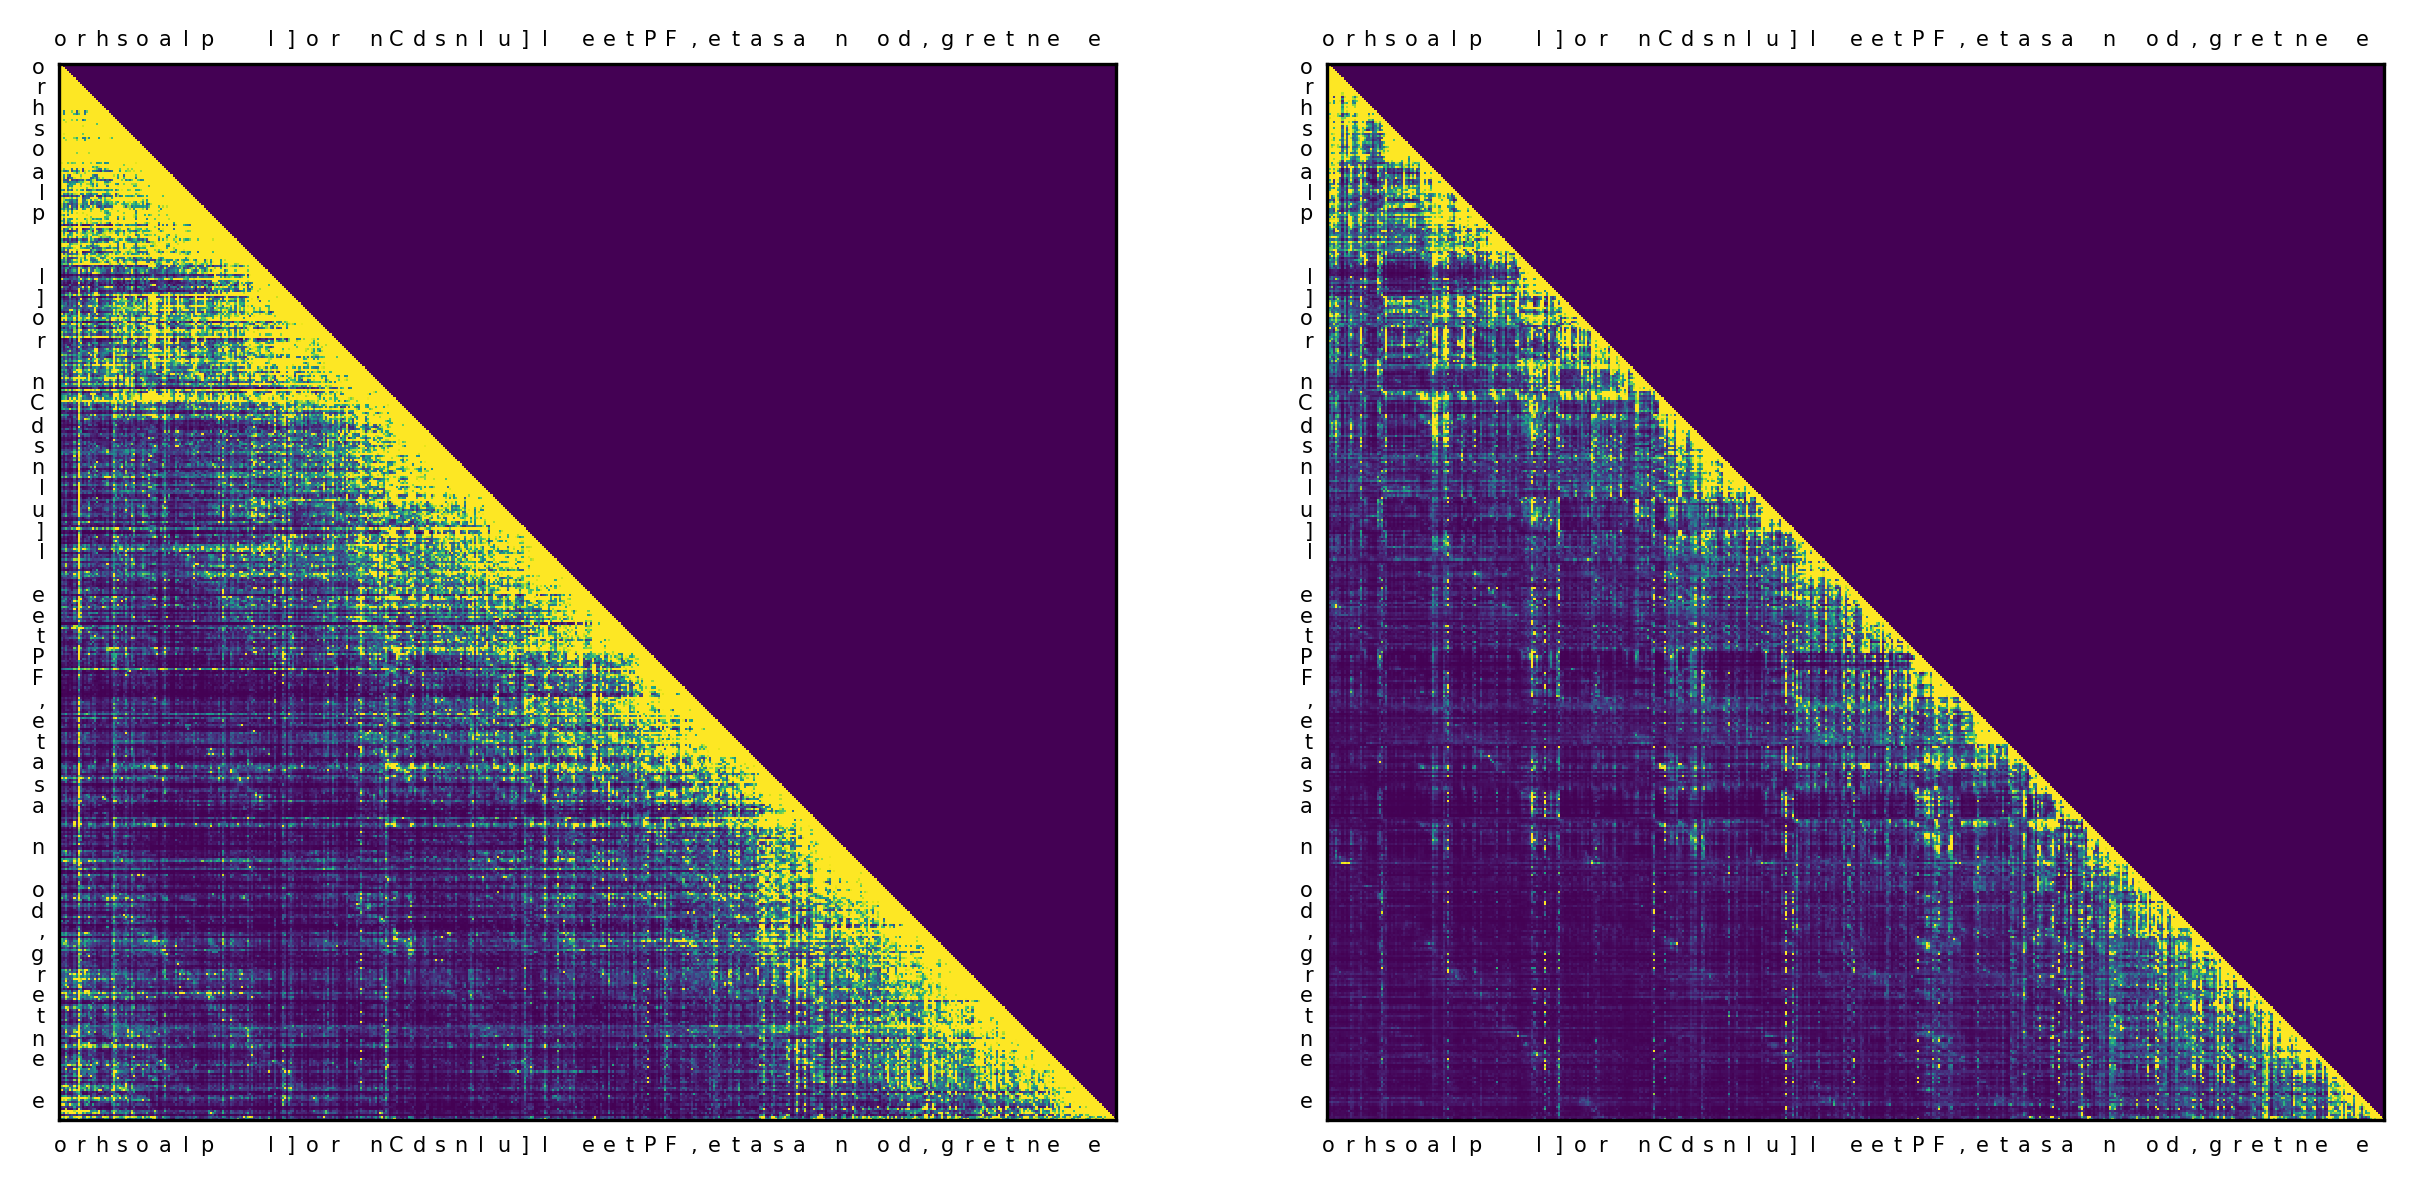

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10, 20), dpi=300)
attn_map_1, attn_map_2 = attn_maps_1[-1], attn_maps_2[-1]
attn_mat_1 = attn_map_1[0].sum(0).numpy()
attn_mat_2 = attn_map_2[0].sum(0).numpy()
vmin_1, vmax_1 = np.percentile(attn_mat_1, [50, 95])
vmin_2, vmax_2 = np.percentile(attn_mat_2, [50, 95])
enc = Tokenizer()
ticks = enc.decode(X[0].cpu().numpy())
num_ticks = min(50, len(ticks))
loc = np.linspace(0, len(ticks), num_ticks, endpoint=False, dtype=int)
ticks = [ticks[i] for i in loc]
for i in range(2):
    axs[i].matshow(eval(f"attn_mat_{2-i}"), cmap='viridis', norm=Normalize(vmin=eval(f'vmin_{i+1}'), vmax=eval(f'vmax_{i+1}')))
    axs[i].tick_params(axis='both', which='both', length=0, labelsize=5, labeltop=True, labelbottom=True)
    axs[i].set_xticks(loc, ticks)
    axs[i].set_yticks(loc, ticks)
# fig = plt.matshow(attn_mat, cmap='viridis', norm=Normalize(vmin=vmin, vmax=vmax))
# fig.figure.set_size_inches(10, 10)
# plt.axis('off')
# plt.xticks(loc, ticks, rotation=0)
# plt.yticks(loc, ticks)
# plt.tick_params(axis='both', which='both', length=0)
# plt.figure(dpi=500)
plt.show()